In [1]:
# Analyze characteristics of bonds and topics - credit rating, returns

In [2]:
import os
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go

init_notebook_mode(connected=True)

import os
import datetime
from gensim.models.ldamodel import LdaModel

import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.DEBUG #this can be more or less verbose

save_path = 'gensim_data'

# from compute_lda import *
# from manage_path import *

DEBUG : Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
%%time
import gzip
import pickle

# make sure the trained corpus equals this dataset!!

# FINRA_TRACE_2014.pkl.zip  FINRA_TRACE_2015.pkl.zip
path = '/cliphomes/amao1/FINRA_TRACE/Data/Pickle/FINRA_TRACE_2014.pkl.zip'
# path_2 = '/cliphomes/amao1/FINRA_TRACE/Data/Pickle/FINRA_TRACE_2015.pkl.zip'
# path= 'FINRA_TRACE_2008.pkl'

# with gzip.open(path, 'rb') as f:
#     data = pickle.load(f)
# data = pd.read_pickle(path).append(pd.read_pickle(path_2),ignore_index=True)

data = pd.read_pickle(path)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6323262 entries, 0 to 6323261
Data columns (total 21 columns):
BOND_SYM_ID            object
CUSIP_ID               object
SCRTY_TYPE_CD          object
ENTRD_VOL_QT           float64
RPTD_PR                float64
RPT_SIDE_CD            object
Year                   float64
document_date          object
TRD_EXCTN_DTTM         datetime64[ns]
TRD_RPT_DTTM           datetime64[ns]
Report_Dealer_Index    object
Contra_Party_Index     object
TRC_ST                 object
RATING_MR              object
RATING_MR_Numeric      float64
OFFERING_DATE          datetime64[ns]
ISSUE_ID               float64
MATURITY               datetime64[ns]
OFFERING_AMT           float64
AMOUNT_OUTSTANDING     float64
Vol_grt_out            float64
dtypes: datetime64[ns](4), float64(8), object(9)
memory usage: 1013.1+ MB
None
CPU times: user 11 s, sys: 2.22 s, total: 13.2 s
Wall time: 13.2 s


In [4]:
print(data.head())

  BOND_SYM_ID   CUSIP_ID SCRTY_TYPE_CD  ENTRD_VOL_QT  RPTD_PR RPT_SIDE_CD  \
0  RBS3706239  00077TAA2          CORP       10000.0  111.245           D   
1  RBS3706239  00077TAA2          CORP        2000.0  113.389           C   
2  RBS3706239  00077TAA2          CORP        5000.0  112.070           C   
3  RBS3706239  00077TAA2          CORP        2000.0  112.640           D   
4  RBS3706239  00077TAA2          CORP       10000.0  112.245           D   

     Year document_date      TRD_EXCTN_DTTM        TRD_RPT_DTTM  ...  \
0  2014.0    2014-01-31 2014-01-31 10:40:23 2014-01-31 10:40:37  ...   
1  2014.0    2014-02-21 2014-02-21 11:19:41 2014-02-21 11:19:57  ...   
2  2014.0    2014-01-24 2014-01-24 15:19:50 2014-01-24 15:20:18  ...   
3  2014.0    2014-02-21 2014-02-21 11:19:41 2014-02-21 11:20:01  ...   
4  2014.0    2014-01-16 2014-01-16 13:41:11 2014-01-16 13:41:27  ...   

  Contra_Party_Index TRC_ST RATING_MR RATING_MR_Numeric  OFFERING_DATE  \
0               2917      T   

In [5]:
# load topic model

from gensim.test.utils import datapath

root_path = '/cliphomes/amao1/FINRA_TRACE/'
models_path = root_path + 'LDAModel/'

# count = 'Dc_v4_100topics'
count = 'count_100topics'

trade_vol_BoW = 'trade_vol_BoW_norm_small_100topics'
# Frac_Outst = 'trade_SV_BoW_small_100topics'
Frac_Outst = 'trade_frac_out_100topics'


model_path = datapath(models_path + Frac_Outst + '/' + Frac_Outst)
# model_path = datapath(models_path + count + '/' + count)
# model_path = datapath(models_path + trade_vol_BoW + '/' + trade_vol_BoW)


lda_model = LdaModel.load(model_path)


INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)
INFO : loading LdaModel object from /cliphomes/amao1/FINRA_TRACE/LDAModel/trade_frac_out_100topics/trade_frac_out_100topics
/cliphomes/amao1/miniconda3/envs/finra/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function

DEBUG : {'uri': '/cliphomes/amao1/FINRA_TRACE/LDAModel/trade_frac_out_100topics/trade_frac_out_100topics', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': {}}
INFO : loading expElogbeta from /cliphomes/amao1/FINRA_TRACE/LDAModel/trade_frac_ou

In [6]:
# %%time
# # daily df - average bond prices, ratings per day
# # sum volume

# daily_df = data.groupby(['BOND_SYM_ID', 'document_date'])['RPTD_PR', 'RATING_MR_Numeric','ENTRD_VOL_QT','MATURITY'].agg(
#     RPTD_PR=('RPTD_PR','mean'),
#     RATING_MR_Numeric=('RATING_MR_Numeric','mean'),
#     vol=('ENTRD_VOL_QT','sum'),
#     num_trades = ('RPTD_PR','size'),
#     maturity = ('MATURITY',lambda x: x.iloc[0])
# ).reset_index()

# daily_df['document_date'] = pd.to_datetime(daily_df['document_date'])
# print(daily_df.head())

In [7]:
# daily_df.to_csv('daily_bond_data_2014_2015.csv')
daily_df = pd.read_csv('daily_bond_data_2014_2015.csv')

In [8]:
# function: given topic ID, get top n bonds it contains, and weights

def get_topic_bonds(topicid):
    
    top_tokens = lda_model.show_topic(topicid, topn=50)
#     print(top_tokens)
    topic_map = pd.DataFrame(data=top_tokens, columns=['BOND_SYM_ID','weight'])

#     zipped = list(zip(*top_tokens))
#     top_token_ids, top_token_ws = list(zipped[0]), list(zipped[1])
#     print(top_token_ids)
#     print(sum(top_token_ws))

    topic_bonds = daily_df[daily_df['BOND_SYM_ID'].isin(topic_map['BOND_SYM_ID'])]
#     print(topic_map['weight'].sum())
    return topic_bonds, topic_map

topic_bonds, topic_map = get_topic_bonds(1)
print(topic_bonds.head())

       Unnamed: 0 BOND_SYM_ID document_date     RPTD_PR  RATING_MR_Numeric  \
70127       70127   AF3867293    2014-01-06  107.300250                9.0   
70128       70128   AF3867293    2014-01-07  107.831000                9.0   
70129       70129   AF3867293    2014-01-08  107.203857                9.0   
70130       70130   AF3867293    2014-01-09  108.050000                9.0   
70131       70131   AF3867293    2014-01-13  107.810000                9.0   

            vol  num_trades    maturity  
70127   45000.0           4  2017-06-19  
70128  680000.0           1  2017-06-19  
70129  375000.0           7  2017-06-19  
70130   15000.0           1  2017-06-19  
70131  348000.0           6  2017-06-19  


In [9]:
# get average credit rating of portfolio
    # more accurate, we would weight changes in rating for the same bond by time
    # weighted sum

# topic_bonds,bond_weights = get_topic_bonds(1)
# avg_ratings_per_bond = topic_bonds.dropna(subset=['RATING_MR_Numeric']).groupby('BOND_SYM_ID')['RATING_MR_Numeric'].mean()
# #     print(avg_ratings_per_bond)

# bond_weights = bond_weights.merge(avg_ratings_per_bond,on='BOND_SYM_ID')
# print(bond_weights)

# avg_rating = np.dot(top_token_ws, avg_ratings_per_bond)/sum(top_token_ws)
# print(avg_rating)
# topic_ratings.append(avg_rating)
    
topic_ratings = []
for topicid in range(100):
    topic_bonds,bond_weights = get_topic_bonds(topicid)
    avg_ratings_per_bond = topic_bonds.dropna(subset=['RATING_MR_Numeric']).groupby('BOND_SYM_ID')['RATING_MR_Numeric'].mean()
#     print(avg_ratings_per_bond)
    
    bond_weights = bond_weights.merge(avg_ratings_per_bond,on='BOND_SYM_ID')
    
    avg_rating = np.dot(bond_weights['weight'], bond_weights['RATING_MR_Numeric'])/sum(bond_weights['weight'])
    print(avg_rating)
    topic_ratings.append(avg_rating)

print(topic_ratings)


9.799694310828182
10.032677026901034
11.355635767110787
9.278875096110221
9.59688469575793
10.675989757540268
10.001888055100354
11.261315675833641
11.023318854674496
9.343721342015845
12.015070706090295
9.59853081095569
10.333510910188927
10.97099399866903
11.163146807212655
11.957272674459194
11.835619293039432
10.307076604843916
10.225764411911898
10.410241577376642
9.899658241163328
13.693682357821835
11.636864555313345
10.179710251575136
10.2866576974119
10.30816089506626
9.398476203419639
11.516184584452866
9.444654735288157
10.60160043495403
9.963043131005591
11.881246361353309
11.866260576859986
10.588671035515619
10.714429415495117
9.704385271117316
10.604244380348375
10.026010949294397
9.290191957702335
11.707007051829418
10.569417180345786
14.411896877751406
10.396187356488895
9.47689682032258
11.41396871549091
12.912170851843504
9.035212676350405
9.933721850568629
10.305428953555385
11.112679132173024
10.074140137135139
8.76553554019058
10.174612250881752
10.24281609306008


Text(0.5, 1.0, 'Histogram of Topic Credit Ratings')

DEBUG : update_title_pos
DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/cliphomes/amao1/miniconda3/envs/finra/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/cliphomes/amao1/miniconda3/envs/finra/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


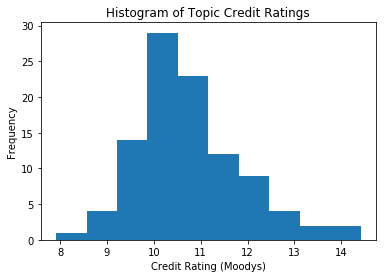

In [10]:
# fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig, ax = plt.subplots()
ax.hist(topic_ratings)

ax.set_xlabel('Credit Rating (Moodys)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Topic Credit Ratings')

# We can set the number of bins with the `bins` kwarg
# axs[0].hist(x, bins=n_bins)
# axs[1].hist(y, bins=n_bins)

In [11]:
fig = go.Figure(
    data=[go.Histogram(x=topic_ratings,nbinsx=20)],

)
fig.update_layout(
#         autosize=False,
#     width=1000,
#     height=500,
#     yaxis_type='log',
    title='Topic Credit Ratings',
    xaxis_title="Rating",
    yaxis_title="Frequency",
)
fig.show()
# print(data[['RATING_MR_Numeric', 'RATING_MR']].drop_duplicates())

/cliphomes/amao1/miniconda3/envs/finra/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning:

invalid value encountered in greater_equal

/cliphomes/amao1/miniconda3/envs/finra/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning:

invalid value encountered in less_equal



Text(0.5, 1.0, 'Histogram of Bond Credit Ratings')

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


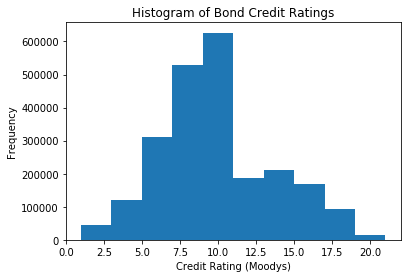

In [12]:
# # credit ratings of all bonds

fig, ax = plt.subplots()
ax.hist(daily_df['RATING_MR_Numeric'])

ax.set_xlabel('Credit Rating (Moodys)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Bond Credit Ratings')

# fig = go.Figure(
#     data=[go.Histogram(x=daily_df['RATING_MR_Numeric'])],
# )
# fig.update_layout(
# #         autosize=False,
# #     width=1000,
# #     height=500,
# #     yaxis_type='log',
# #     xaxis_type='log',
#     title='Bond Credit Ratings',
#     xaxis_title="Rating",
#     yaxis_title="Frequency",
# )
# fig.show()

In [13]:
# # examine returns of all bonds
# # 85% of bonds were traded in Jan 2014 and Dec 2015

# time_filtered_daily_df = daily_df[(daily_df['document_date'] < datetime.datetime(2014,2,1)) | (daily_df['document_date'] > datetime.datetime(2015,11,30))]
# print(len(daily_df.groupby('BOND_SYM_ID')), len(time_filtered_daily_df.groupby('BOND_SYM_ID')))

# returns = time_filtered_daily_df.groupby('BOND_SYM_ID')['RPTD_PR'].agg(start_price=('start',lambda x: x[x.index.min()]), 
#                                                                 end_price=('end',lambda x: x[x.index.max()]),
#                                                                )
# returns['return'] = (returns['end_price']-returns['start_price'])/returns['start_price']
# returns = returns[returns['return'] < 2]

# print(returns)

# fig = go.Figure(
#     data=[go.Histogram(x=returns['return'])],
# )
# fig.update_layout(
# #         autosize=False,
# #     width=1000,
# #     height=500,
#     yaxis_type='log',
# #     xaxis_type='log',
#     title='Bond Returns',
#     xaxis_title="Return",
#     yaxis_title="Frequency",
# )
# fig.show()

In [14]:
# print(returns.sort_values(by='return', ascending=False).head())

# # daily_df.to_csv('daily_bond_data_2014_2015.csv')

# single_bond_df = daily_df[daily_df['BOND_SYM_ID']=='LMBR.GA']
# single_bond_df['document_date'] = pd.to_datetime(single_bond_df['document_date'])
# single_bond_df = single_bond_df.set_index('document_date')
# print(single_bond_df.head())
# single_bond_df.plot(y='RPTD_PR')

# # exploratory analysis of price

# fig = go.Figure(
#     data=[go.Histogram(x=daily_df['RPTD_PR'])],
# )
# fig.update_layout(
# #         autosize=False,
# #     width=1000,
# #     height=500,
#     yaxis_type='log',
# #     xaxis_type='log',
#     title='Bond Prices',
#     xaxis_title="Rating",
#     yaxis_title="Frequency",
# )
# fig.show()

In [15]:
# get the return of a topic
    # get returns - annual return per bond (earliest/latest trade)
    # end-start / start
    # weight, sum
    # index df by date
    # groupby bond ID, take the earliest

def get_topic_return(topicid):
    topic_bonds,bond_weights = get_topic_bonds(topicid)
    
    topic_bonds = topic_bonds.set_index('document_date')

#     for name,group in topic_bonds.groupby('BOND_SYM_ID')['RPTD_PR']:
#         start, end = group[group.index.min()], group[group.index.max()]
#         print((end-start)/start)
    returns = topic_bonds.groupby('BOND_SYM_ID')['RPTD_PR'].agg(start_price=('start',lambda x: x[x.index.min()]), 
                                                                end_price=('end',lambda x: x[x.index.max()]),
                                                               )

    returns['return'] = (returns['end_price']-returns['start_price'])/returns['start_price']
    returns = returns.reset_index()
#     print(returns)

    bond_weights = bond_weights.merge(returns,on='BOND_SYM_ID')

    avg_returns = np.dot(bond_weights['weight'], bond_weights['return'])/sum(bond_weights['weight'])
    print(avg_returns)
    return avg_returns

# get_topic_return(1)

topic_returns = []
for topicid in range(100):
    topic_returns.append(get_topic_return(topicid))

# print(topic_returns)
print(list(filter(lambda x: x>=0, topic_returns)))

fig = go.Figure(
    data=[go.Histogram(x=topic_returns)],
)
fig.update_layout(
#         autosize=False,
#     width=1000,
#     height=500,
#     yaxis_type='log',
    title='Topic Returns',
    xaxis_title="Return",
    yaxis_title="Frequency",
)
fig.show()


INFO : Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO : NumExpr defaulting to 8 threads.


-0.025825208589360722
-0.03856919047567689
-0.12871627641049402
-0.058118263917055886
-0.03807110453333628
-0.0538660705902337
-0.07391328295761085
0.00584746939441565
-0.010682226152744292
-0.0006173461668072374
-0.2218861879612729
-0.005823460427768566
-0.03388702479569655
-0.0638396707635674
-0.038890274855526714
-0.1364990036713353
-0.09867156809827192
-0.003223818413632075
-0.048809942401409144
-0.0619212941837348
-0.06833828247094098
-0.07442235775508198
-0.11155200175835729
-0.024483728859447104
0.015542425850002149
-0.052760075343242126
-0.0004900921062519043
-0.1072609062495287
0.009775569538770436
-0.09935645615829049
-0.007393460986613789
-0.11435365437516674
-0.06081036820043061
-0.04448793780384581
-0.013746091897101926
-0.08270979362830064
-0.02355583842691036
-0.1276145029530026
-0.0377652956634167
-0.08324440728992201
-0.04111297457718684
-0.16597406600256348
-0.06638765439399646
-0.028762303362903644
-0.0900898698367787
-0.07636395271374688
-0.09529289955394943
-0.0136

In [16]:

df_merged = pd.read_csv('FINRA_TRACE/TopicModeling/bonds_info.csv')
print(df_merged.info())
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14423 entries, 0 to 14422
Data columns (total 12 columns):
Unnamed: 0        14423 non-null int64
BOND_SYM_ID       14422 non-null object
CUSIP_ID          14423 non-null object
ISSUER_ID         12712 non-null float64
COMPLETE_CUSIP    12712 non-null object
AGENT_ID          12712 non-null float64
CUSIP_NAME        12712 non-null object
INDUSTRY_GROUP    12711 non-null float64
INDUSTRY_CODE     12712 non-null float64
PARENT_ID         12709 non-null float64
NAICS_CODE        12570 non-null float64
SIC_CODE          12628 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.3+ MB
None


,Unnamed: 0,BOND_SYM_ID,CUSIP_ID,ISSUER_ID,COMPLETE_CUSIP,AGENT_ID,CUSIP_NAME,INDUSTRY_GROUP,INDUSTRY_CODE,PARENT_ID,NAICS_CODE,SIC_CODE
0,0,BNPQF3706239,00077TAA2,40263.0,00077TAA2,5.0,ABN AMRO BK N V N Y BRH,2.0,20.0,4618.0,52211.0,6029.0
1,5,RBS3706239,00077TAA2,40263.0,00077TAA2,5.0,ABN AMRO BK N V N Y BRH,2.0,20.0,4618.0,52211.0,6029.0
2,13,BNPQF3706241,00077TAB0,40263.0,00077TAB0,5.0,ABN AMRO BK N V N Y BRH,2.0,20.0,4618.0,52211.0,6029.0
3,14,RBS3706241,00077TAB0,40263.0,00077TAB0,5.0,ABN AMRO BK N V N Y BRH,2.0,20.0,4618.0,52211.0,6029.0
4,36,TRP3706374,001814AQ5,21.0,001814AQ5,21.0,ANR PIPELINE CO,3.0,31.0,42708.0,48621.0,4922.0


In [17]:
# print(df_merged['INDUSTRY_GROUP'].value_counts())
# print(df_merged['INDUSTRY_CODE'].value_counts())
# print(df_merged['NAICS_CODE'].value_counts())
# print(df_merged['SIC_CODE'].value_counts())

df_merged['NAICS_CODE'].astype(str).str[:2].value_counts()

52    2786
na    1853
33    1438
22    1400
32    1190
21    1122
51    1049
48     665
31     571
53     493
44     260
45     227
42     214
54     179
62     170
23     164
55     147
72     126
56     126
71      70
61      68
81      35
49      31
11      25
92      14
Name: NAICS_CODE, dtype: int64

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


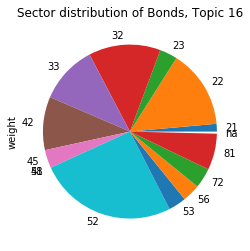

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


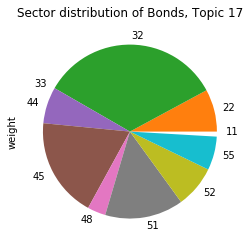

In [18]:
# plot sector distribution of topic

def sector_distro(topicid):
    topic_bonds,bond_weights = get_topic_bonds(topicid)
    
    topic_bonds = topic_bonds.set_index('document_date')
    
#     print(bond_weights)
#     print(bond_weights.sum())
    
    merged = (bond_weights.merge(df_merged[['BOND_SYM_ID','NAICS_CODE']]))
    merged['NAICS_CODE'] = merged['NAICS_CODE'].astype(str).str[:2]
#     print(merged)
    merged = merged.groupby('NAICS_CODE')['weight'].agg(sum)
#     print(merged)
    ax = merged.plot(kind='pie',y='weight')
    ax.set_title('Sector distribution of Bonds, Topic ' + str(topicid))

for i in range(16,18):
    sector_distro(i)
    plt.show()

# sector_distro(0)
# plt.show()

      BOND_SYM_ID           vol NAICS_CODE
0            A.GC  9.879700e+07         33
1            A.GE  8.065700e+07         33
2            A.GF  3.234660e+08         33
3        A3900782  2.180700e+08         33
4        A4020252  3.250410e+08         33
...           ...           ...        ...
14417  ZMH4221428  3.744320e+08         na
14418  ZQK4029107  1.303575e+09         45
14419  ZQK4062844  8.585410e+08         45
14420     ZUAN.GA  4.760400e+07         na
14421     ZUAN.GB  9.000000e+06         na

[14422 rows x 3 columns]


Text(0.5, 1.0, 'Sector distribution of Bonds (Volume-weighted)')

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


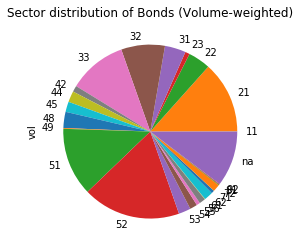

In [19]:
# sector distribution of the universe - weighted by volume


# sector distribution of the universe - weighted by volume

vols = daily_df.groupby('BOND_SYM_ID')['vol'].sum()
# df_uni = df_merged[['BOND_SYM_ID','NAICS_CODE']]
# df_uni['vol'] = vols
# print(df_uni)
# print(vols)
vols = vols.to_frame().merge(df_merged[['BOND_SYM_ID','NAICS_CODE']], on='BOND_SYM_ID')
vols['NAICS_CODE'] = vols['NAICS_CODE'].astype(str).str[:2]
print(vols)
sorted_vols = (vols.sort_values(by='vol', ascending=False))

sorted_vols = sorted_vols.groupby('NAICS_CODE')['vol'].agg(sum)
ax = sorted_vols.head(1000).plot(kind='pie',y='vol')
ax.set_title('Sector distribution of Bonds (Volume-weighted)')

# sorted_vols.head(10).plot(kind='pie',y='vol',labels=sorted_vols['NAICS_CODE'])

# merged = (bond_weights.merge(df_merged[['BOND_SYM_ID','NAICS_CODE']]))
# merged['NAICS_CODE'] = merged['NAICS_CODE'].astype(str).str[:2]
# merged = merged.groupby('NAICS_CODE')['weight'].agg(sum)
# #     print(merged)
# merged.plot(kind='pie',y='weight')

In [20]:
# top volume

def get_vol(topicid):
    topic_bonds,bond_weights = get_topic_bonds(topicid)
    
    topic_bonds = topic_bonds.set_index('document_date')
    vols = topic_bonds.groupby('BOND_SYM_ID')['vol'].sum()
#     print(vols)
    bond_weights = bond_weights.merge(vols,on='BOND_SYM_ID')

    weighted_vols = np.dot(bond_weights['weight'], bond_weights['vol'])/sum(bond_weights['weight'])
    print(weighted_vols)
#     vol = topic_bonds['vol'].sum()
#     return vol
    return weighted_vols

vols = []
for i in range(100):
#     print(i)
    vols.append(get_vol(i))

print(np.argmax(vols))

fig = go.Figure(
    data=[go.Histogram(x=vols)],
)
fig.update_layout(
#         autosize=False,
#     width=1000,
#     height=500,
#     yaxis_type='log',
    title='Topic Volumes',
    xaxis_title="Volume",
    yaxis_title="Frequency",
)
fig.show()

500114207.4093597
467499598.4995834
595665835.7869748
630989928.8415741
706275295.3121327
775320187.4933997
537469554.0004115
569328718.0288582
866922218.6313093
984896667.8226331
712184310.5764481
486531626.28897494
223485142.32204276
439717041.04343265
431041800.1978465
858967316.8536028
916656121.6010627
555449857.0406002
403743655.2470366
290817579.8601932
571926052.184287
823301353.375458
682720438.2463158
549052627.6820695
429261182.0088774
523663210.321535
386981820.77615124
926303959.6248072
304223219.3013684
577808819.0081352
415387787.26993954
677994311.4513841
485925545.86318123
427103746.0159843
520299382.2822044
585007012.557347
683488548.3443979
1032515741.0644425
628714344.1968962
928743840.7009201
1160502128.7661033
821213691.1381738
997572446.1608073
470927698.19289625
316508818.9541281
615622478.6443325
819535393.5399125
779827034.7247201
536252292.53028816
842763215.2342551
729492818.0326675
510223074.30292565
573400533.3363179
637384777.7014035
501621590.84169436
79

In [21]:
# volume over time

def get_vol_over_time(topicid):
    topic_bonds,bond_weights = get_topic_bonds(topicid)
#     print(topic_bonds)
    
#     topic_bonds = topic_bonds.set_index('document_date')
#     daily_vol = topic_bonds.groupby('document_date')['vol'].sum()
    daily_vol = []
    dates = []
    for name,group in topic_bonds.groupby('document_date'):
        group = group.merge(bond_weights,on='BOND_SYM_ID')
#         print(group)
        vol = np.dot(group['weight'], group['vol'])/sum(group['weight'])
        daily_vol.append(vol)
        dates.append(name)

    daily_vol = pd.DataFrame(daily_vol, index=dates)
#     ax = daily_vol.plot()
#     ax.set_title('volume over time for topic ' + str(topicid))
#     return ax
    return daily_vol

#     vols = topic_bonds.groupby('BOND_SYM_ID')['vol'].sum()
#     print(vols)
#     bond_weights = bond_weights.merge(vols,on='BOND_SYM_ID')

#     weighted_vols = np.dot(bond_weights['weight'], bond_weights['vol'])/sum(bond_weights['weight'])
#     print(weighted_vols)
#     vol = topic_bonds['vol'].sum()
#     return vol
#     return weighted_vols


# for i in range(10):
#     get_vol_time(i)
#     plt.show()

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


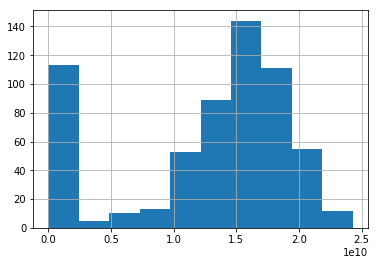

In [22]:
# plot volume of all bonds over time
import plotly.express as px


daily_vol = daily_df.groupby('document_date')['vol'].sum()
# daily_vol = daily_vol.resample('3D').sum()
# print(daily_vol.head(20))
# daily_vol.dropna().plot.line()

daily_vol.hist()
# print(daily_vol.sort_values())

# daily_vol = daily_vol.to_frame().reset_index()

# fig = px.line(daily_vol,x='document_date',y='vol',title='Daily Volume')
# fig.show()


DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


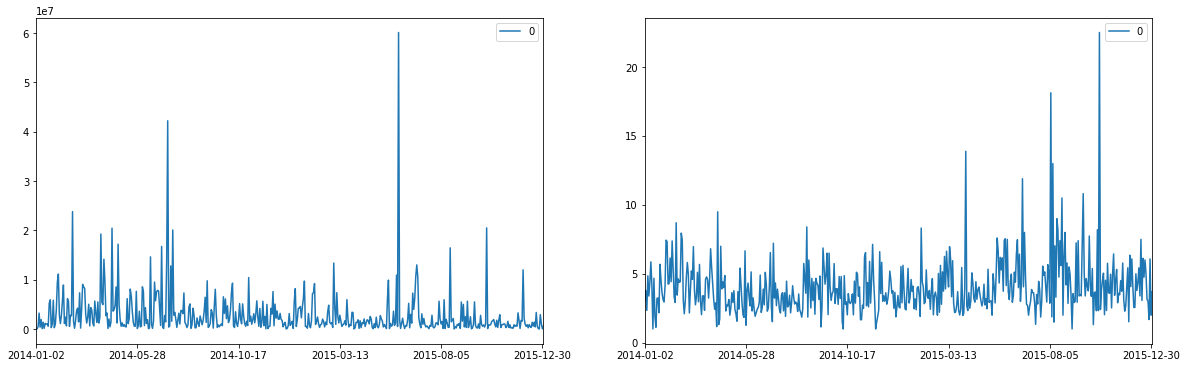

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


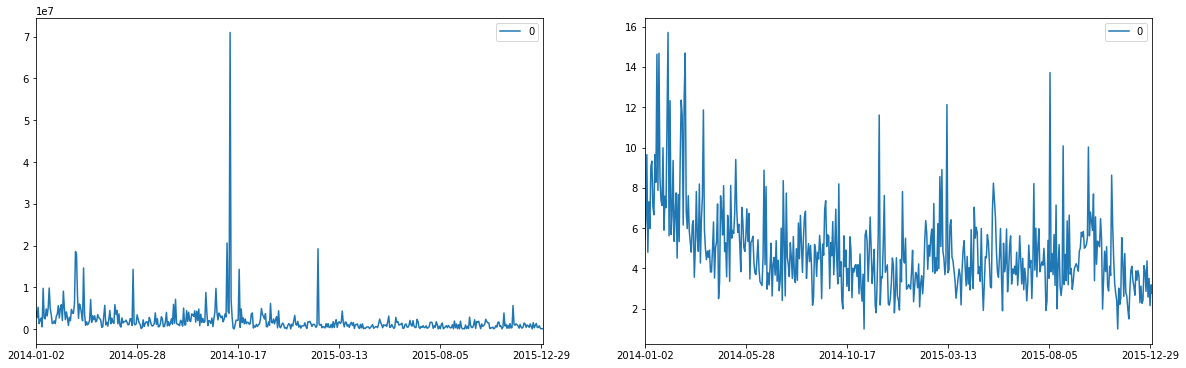

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


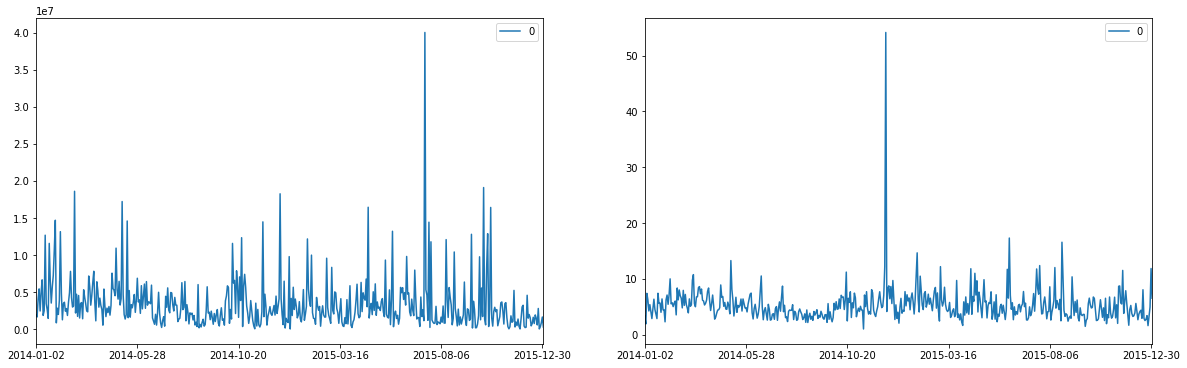

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


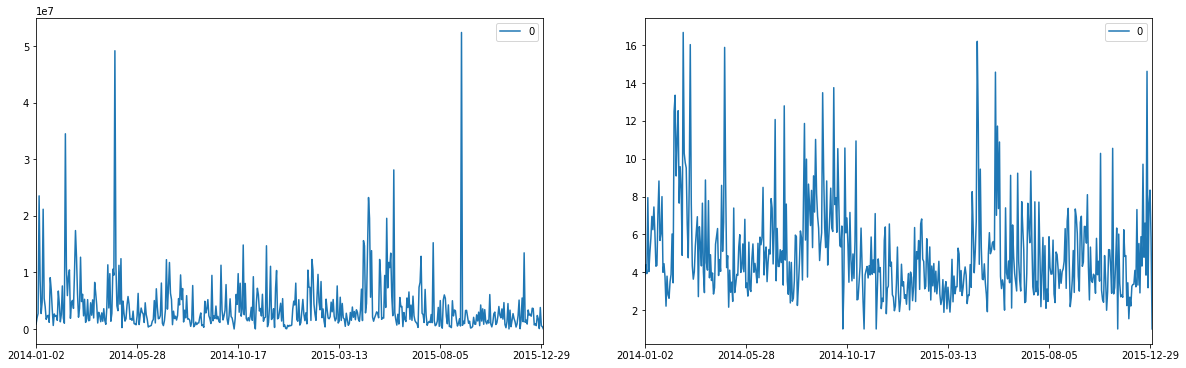

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


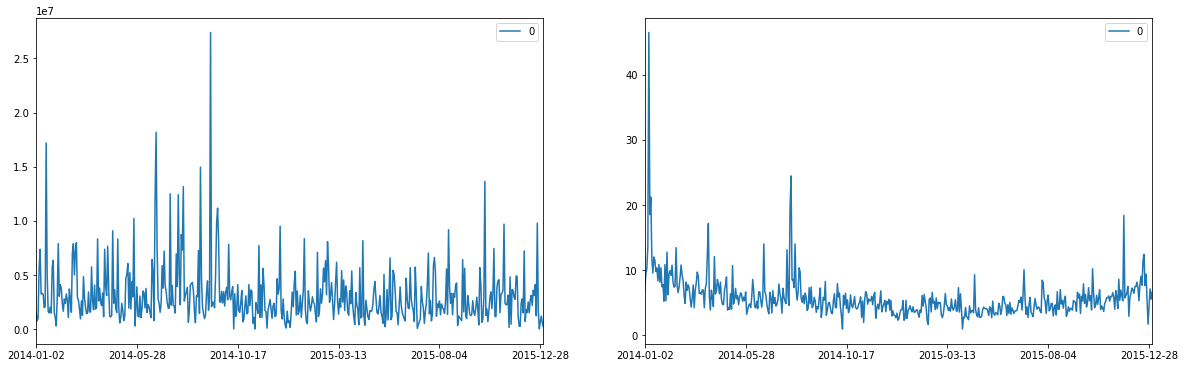

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


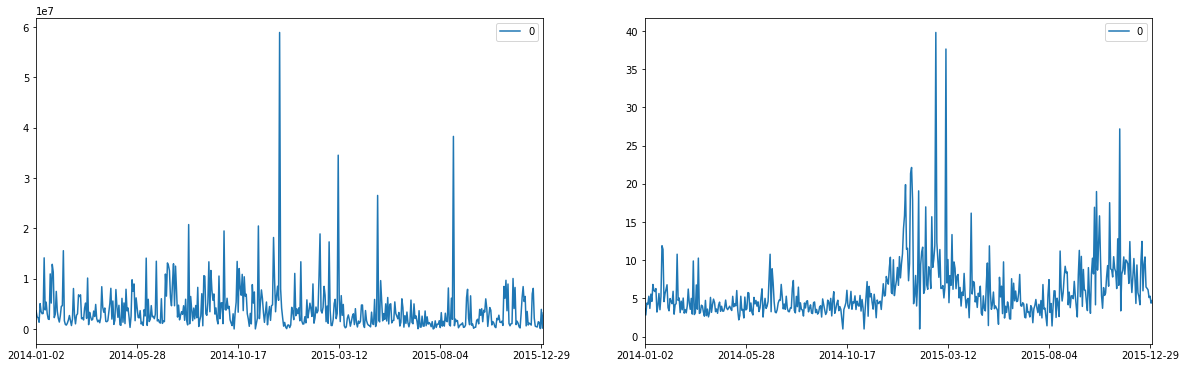

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


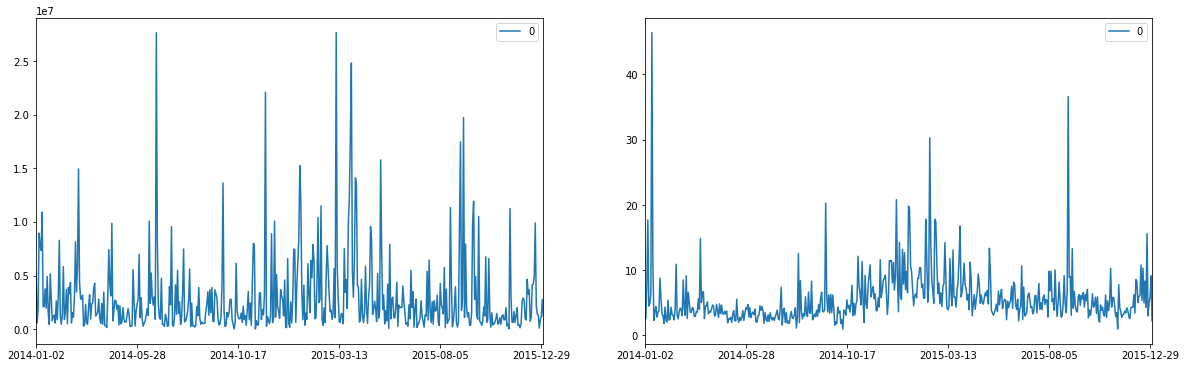

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


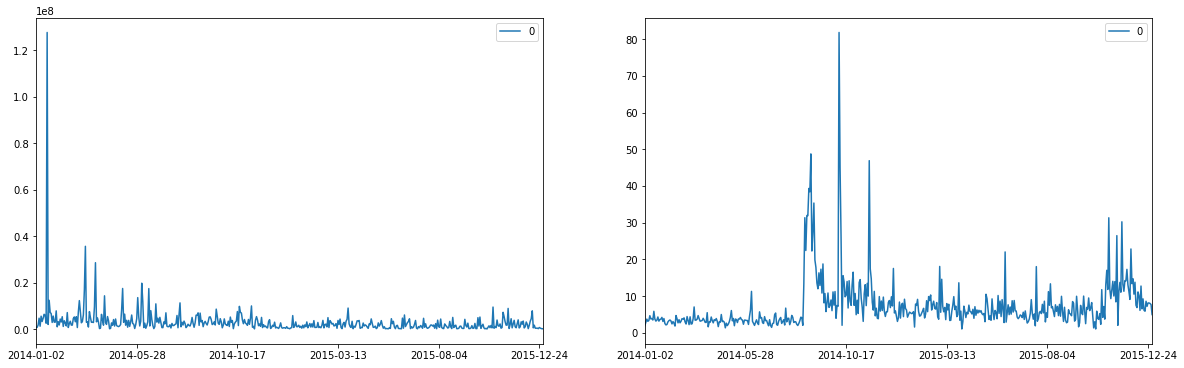

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


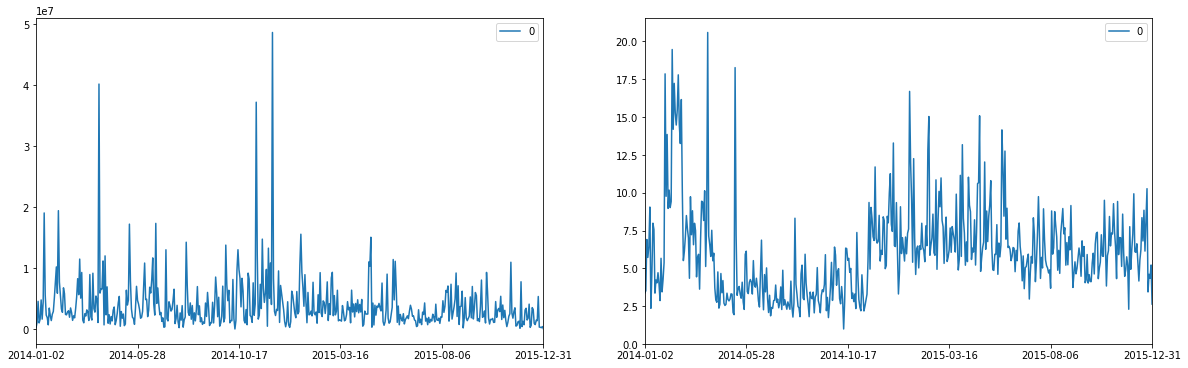

DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos
DEBUG : update_title_pos


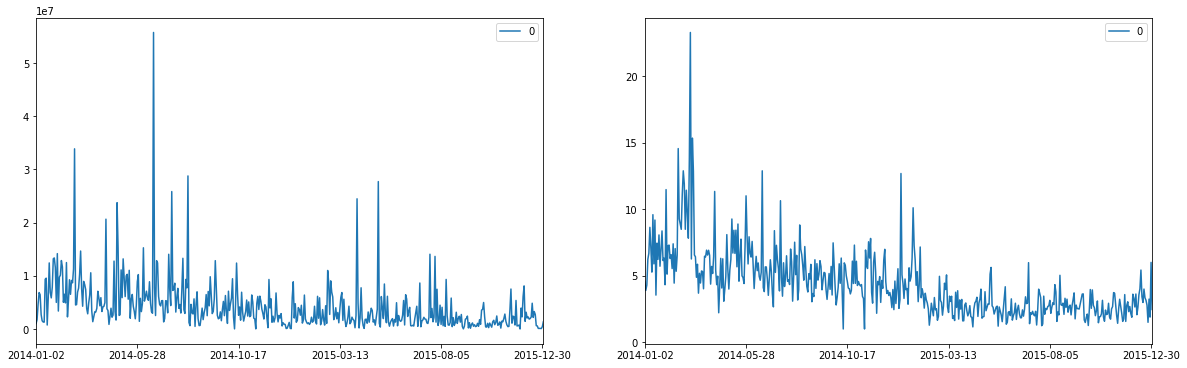

In [23]:
# count of trades over time

def get_count_over_time(topicid):
    topic_bonds,bond_weights = get_topic_bonds(topicid)
#     print(topic_bonds)
    
#     topic_bonds = topic_bonds.set_index('document_date')
#     daily_vol = topic_bonds.groupby('document_date')['vol'].sum()
    daily_count = []
    dates = []
    
#     daily_count = topic_bonds.groupby('document_date').size()
    for name,group in topic_bonds.groupby('document_date'):
        group = group.merge(bond_weights,on='BOND_SYM_ID')
#         print(group)
        vol = np.dot(group['weight'], group['num_trades'])/sum(group['weight'])
        daily_count.append(vol)
        dates.append(name)

    daily_count = pd.DataFrame(daily_count, index=dates)
#     ax = daily_count.plot()
#     ax.set_title('count over time for topic ' + str(topicid))
#     return ax
    return daily_count


# for i in range(10):
#     get_count_over_time(i)
#     plt.show()

for i in range(10):

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,6))
#     fig.suptitle('Horizontally stacked subplots')
#     ax1.plot(x, y)
#     ax2.plot(x, -y)
    get_vol_over_time(i).plot(ax=ax1)
    get_count_over_time(i).plot(ax=ax2)
    plt.show()

In [24]:
# plot entropy v volume


annual_entropy = [7.660846664662012, 7.708777606958926, 7.558321380281885, 7.751287481679808, 7.7628591811969585, 7.57415266706557, 7.689849485766237, 7.520800786672501, 7.708489979242031, 7.765610451597894, 7.728231861806268, 7.497901657644084, 7.62606861082925, 7.64345610644093, 7.744614270979461, 7.659406664187253, 7.692676577734565, 7.522992433123245, 7.3393792080072, 7.696597341988666, 7.563079539579505, 7.275738453113668, 7.694149537267553, 7.722538850646992, 7.3647978002064605, 7.617824420049853, 7.648888086690388, 7.707402628265736, 7.8201723272741, 7.200428711680722, 7.580870588792014, 7.655843629923007, 7.818142268378213, 7.586149882435459, 7.800386594277909, 7.658935142374283, 7.553380331664771, 7.676637030627818, 7.587060610181689, 7.700179549942666, 7.641381617940118, 7.771928401272959, 7.703352202707713, 7.6701384330284315, 7.76529038666447, 7.685998687473994, 7.633325313880317, 7.69077682773376, 7.790500194900928, 7.684881236170046, 7.745159102760627, 7.7480222301651835, 7.694187261220108, 7.39457487256607, 7.751763371649844, 7.4919766529197656, 7.510039847006007, 7.755242156522817, 6.851370525338804, 7.479200463169201, 7.702393002068736, 7.657521506561681, 7.3115939080191605, 7.665477435397864, 7.682192640173033, 7.7226328221766165, 6.70634654529645, 7.529330063635575, 7.59761660240501, 7.801867711292735, 7.34480953615393, 7.723866637547134, 7.706107300338461, 7.713665484448977, 7.342941938079972, 7.613051686543135, 7.810217778738112, 7.717180800749291, 7.6764722619722, 7.7059127154417695, 7.752075913073974, 7.7665061295553, 7.822271776983461, 7.732121875199017, 7.7025373998321705, 7.525856602613863, 7.520066562008864, 7.605906056193753, 7.541091006731836, 7.385160136607788, 7.624355694573325, 7.787444779634321, 7.688630835549769, 7.410830680031367, 7.556118974028105, 7.528413569521115, 7.726222646551628, 7.74649233645637, 7.515661510195893, 7.399332916179734]
# print(vols)

fig = go.Figure(
    data=[go.Scatter(x=annual_entropy, y=vols, mode='markers')],
)
fig.update_layout(
#         autosize=False,
#     width=1000,
#     height=500,
#     yaxis_type='log',
    title='Topic Entropy v Volume',
    xaxis_title="Entropy",
    yaxis_title="Volume",
)
fig.show()




In [25]:
# return weight of top sector

def top_sector(topicid):
    topic_bonds,bond_weights = get_topic_bonds(topicid)
    
    topic_bonds = topic_bonds.set_index('document_date')
    
#     print(bond_weights)
#     print(bond_weights.sum())
    
    merged = (bond_weights.merge(df_merged[['BOND_SYM_ID','NAICS_CODE']]))
    merged['NAICS_CODE'] = merged['NAICS_CODE'].astype(str).str[:2]
#     print(merged)
    merged = merged.groupby('NAICS_CODE')['weight'].agg(sum)
    return (merged.idxmax(), merged.max())
#     ax = merged.plot(kind='pie',y='weight')
#     ax.set_title('Sector distribution of Bonds, Topic ' + str(topicid))

# print(top_sector_weight(1))

# plot volume v top sector weight

top_sectors = [top_sector(i) for i in range(100)]
# zip(*top_sectors)
# print(top_sectors)

zipped = list(zip(*top_sectors))
top_sectors, top_sector_weights = zipped[0], zipped[1]

# fig = go.Figure(
#     data=[go.Scatter(x=vols, y=top_sectors, mode='markers')],
# )
# fig.update_layout(
# #         autosize=False,
# #     width=1000,
# #     height=500,
# #     yaxis_type='log',
#     title='Topic Volume v Top Sector Weight',
#     xaxis_title="Volume",
#     yaxis_title="Top Sector Weight",
# )
# fig.show()

In [26]:
# bond entropy (annual) - AKA uncertainty/spread over time

# groupby bond id, day
# groupby bond id, year
# calculate p_i

day_sum = data.groupby(['BOND_SYM_ID', 'document_date'])['ENTRD_VOL_QT'].agg({'daily_vol': np.sum}).reset_index()
# print(day_sum.head())

# year_sum = data.groupby(['BOND_SYM_ID', 'Year'])['ENTRD_VOL_QT'].agg({'annual_vol': np.sum})
# print(year_sum.head())

day_sum['Year'] = day_sum['document_date'].str[0:4]
day_sum['annual_vol'] = day_sum.groupby(['BOND_SYM_ID', 'Year'])['daily_vol'].transform(np.sum)
print(day_sum.head())

day_sum['p'] = day_sum['daily_vol']/day_sum['annual_vol']
print(day_sum.head(20))

#sanity check: p sums to 1?
# print(day_sum.groupby(['BOND_SYM_ID', 'Year']).sum().head())

day_sum['day_entropy'] = -day_sum['p'] * np.log(day_sum['p'])
# print(day_sum['day_entropy'].isna().sum())

annual_entropy = day_sum.groupby(['BOND_SYM_ID'])['day_entropy'].sum()
print(annual_entropy.head())

/cliphomes/amao1/miniconda3/envs/finra/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




  BOND_SYM_ID document_date  daily_vol  Year  annual_vol
0        A.GC    2014-01-02   500000.0  2014  76445000.0
1        A.GC    2014-01-03   124000.0  2014  76445000.0
2        A.GC    2014-01-06  4227000.0  2014  76445000.0
3        A.GC    2014-01-07     8000.0  2014  76445000.0
4        A.GC    2014-01-08     3000.0  2014  76445000.0
   BOND_SYM_ID document_date  daily_vol  Year  annual_vol         p
0         A.GC    2014-01-02   500000.0  2014  76445000.0  0.006541
1         A.GC    2014-01-03   124000.0  2014  76445000.0  0.001622
2         A.GC    2014-01-06  4227000.0  2014  76445000.0  0.055295
3         A.GC    2014-01-07     8000.0  2014  76445000.0  0.000105
4         A.GC    2014-01-08     3000.0  2014  76445000.0  0.000039
5         A.GC    2014-01-09    41000.0  2014  76445000.0  0.000536
6         A.GC    2014-01-10   150000.0  2014  76445000.0  0.001962
7         A.GC    2014-01-13   157000.0  2014  76445000.0  0.002054
8         A.GC    2014-01-14  2439000.0  2014 

In [27]:
# topics are rly bad??
# print(data[data['BOND_SYM_ID'] == 'RDEN.GD'])
# data[data['BOND_SYM_ID'] == 'EMC4014769']

# function: given topic ID, get top n bonds it contains, and weights

def get_topic_bonds_2(topicid):
    
    top_tokens = lda_model.show_topic(topicid, topn=30)
#     print(top_tokens)
    topic_map = pd.DataFrame(data=top_tokens, columns=['BOND_SYM_ID','weight'])

#     zipped = list(zip(*top_tokens))
#     top_token_ids, top_token_ws = list(zipped[0]), list(zipped[1])
#     print(top_token_ids)
#     print(sum(top_token_ws))

    topic_bonds = day_sum[day_sum['BOND_SYM_ID'].isin(topic_map['BOND_SYM_ID'])]
#     print(topic_map['weight'].sum())
    return topic_bonds, topic_map

topic_bonds, topic_map = get_topic_bonds(1)
print(topic_bonds.head())
print(topic_map['weight'].sum())

def get_topic_entropy(topicid):
    
    topic_bonds, topic_map = get_topic_bonds_2(topicid)
    daily_topic_dates, daily_topic_weights = [], []
#     print((topic_map['weight'].sum()))
    for day,group in topic_bonds.groupby('document_date'):

        try:
            group = group[['BOND_SYM_ID','p']].merge(topic_map, on='BOND_SYM_ID')
#             print(group.shape)
#             print(np.dot(topic_map['weight'], topic_map['p']))
            w_t = np.dot(group['weight'], group['p'])
            daily_topic_dates.append(day)
            daily_topic_weights.append(w_t)

        except Exception as e:
            print(e)
    
    
    daily_topic_dates = pd.to_datetime(daily_topic_dates)
    # add the result as Series column to df
    daily_topic_weights = pd.Series(data=daily_topic_weights, index=daily_topic_dates)
#     print(daily_topic_weights)

    annual_topic_weight = daily_topic_weights.dropna().sum()
#     print(annual_topic_weight)

    topic_probs = daily_topic_weights / annual_topic_weight
#     print(sum(topic_probs))
#     print(topic_probs)
    return (-np.dot(topic_probs,np.log2(topic_probs)))

    # topic_weight_df[topicid] = daily_topic_weights
#     topic_weight_df[topicid] = topic_probs
#     print(topic_weight_df)


annual_entropies = []
for i in range(100):
    ent = get_topic_entropy(i)
    annual_entropies.append(ent)
    print(ent)

# print(annual_entropies)
# print(get_topic_entropy(1))

       Unnamed: 0 BOND_SYM_ID document_date     RPTD_PR  RATING_MR_Numeric  \
70127       70127   AF3867293    2014-01-06  107.300250                9.0   
70128       70128   AF3867293    2014-01-07  107.831000                9.0   
70129       70129   AF3867293    2014-01-08  107.203857                9.0   
70130       70130   AF3867293    2014-01-09  108.050000                9.0   
70131       70131   AF3867293    2014-01-13  107.810000                9.0   

            vol  num_trades    maturity  
70127   45000.0           4  2017-06-19  
70128  680000.0           1  2017-06-19  
70129  375000.0           7  2017-06-19  
70130   15000.0           1  2017-06-19  
70131  348000.0           6  2017-06-19  
0.9928495665505552
6.711621176660399
7.003024486956232
7.13454598967768
6.8734838505543285
7.310118124903453
7.192238601515184
6.714660074349078
6.72790014796477
7.09263389098874
7.190542452208151
7.28691243072255
6.934547131850102
6.737551563847183
6.762952481399389
6.816899137

In [28]:

# # TopicNo, TopSector, TopSectorWeight, Rating, Volume, Entropy

# top_sector_weights = top_sectors

# topic_ratings
# vols

for arr in [top_sectors,top_sector_weights,topic_ratings,vols,annual_entropies]:
    print(len(arr))
topic_data = pd.DataFrame({'topic_id':range(1,101),'top_sector':top_sectors,'top_sector_weight':top_sector_weights, 'ratings':topic_ratings, 'volume':vols, 'entropy':annual_entropies})
topic_data.to_csv('topic_data_vol.csv')
print(topic_data)

# # def get_data(topicid):
# #     topic_bonds,bond_weights = get_topic_bonds(topicid)
    
    
# #     merged = (bond_weights.merge(df_merged[['BOND_SYM_ID','NAICS_CODE']]))
# #     merged['NAICS_CODE'] = merged['NAICS_CODE'].astype(str).str[:2]
# # #     print(merged)
# #     merged = merged.groupby('NAICS_CODE')['weight'].agg(sum)
# #     return (merged.max())


# # #     print(topic_bonds)
    
# # #     topic_bonds = topic_bonds.set_index('document_date')
# # #     daily_vol = topic_bonds.groupby('document_date')['vol'].sum()
# #     daily_vol = []
# #     dates = []
# #     for name,group in topic_bonds.groupby('document_date'):
# #         group = group.merge(bond_weights,on='BOND_SYM_ID')
# # #         print(group)
# #         vol = np.dot(group['weight'], group['vol'])/sum(group['weight'])
# #         daily_vol.append(vol)
# #         dates.append(name)

# #     daily_vol = pd.DataFrame(daily_vol, index=dates)
# # #     ax = daily_vol.plot()
# # #     ax.set_title('volume over time for topic ' + str(topicid))
# # #     return ax
# #     return [topicid+1,daily_vol]

# # top_sectors = [top_sector_weight(i) for i in range(100)]
# # # print(top_sectors)

100
100
100
100
100
    topic_id top_sector  top_sector_weight    ratings        volume   entropy
0          1         52           0.302427   9.799694  5.001142e+08  6.711621
1          2         52           0.313214  10.032677  4.674996e+08  7.003024
2          3         52           0.167138  11.355636  5.956658e+08  7.134546
3          4         52           0.296195   9.278875  6.309899e+08  6.873484
4          5         52           0.198502   9.596885  7.062753e+08  7.310118
..       ...        ...                ...        ...           ...       ...
95        96         52           0.255996  12.913535  8.393524e+08  6.729886
96        97         52           0.208607  14.136451  5.295314e+08  6.555808
97        98         52           0.330980  13.135798  6.460181e+08  6.840936
98        99         52           0.338228   8.948959  1.175372e+09  7.279444
99       100         52           0.057403   9.977994  9.113489e+08  7.194757

[100 rows x 6 columns]
